# Regression Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

In [0]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')

In [201]:
df = df.drop(['Id'], axis=1)
df.shape

(1460, 80)

In [202]:
df['GrLivAreaOverallQual'] = df['GrLivArea']*df['OverallQual']
df['GTBB'] = df['GarageCars']+df['TotRmsAbvGrd']+df['BsmtFinSF1']+df['BsmtFullBath']
df.head().T

,0,1,2,3,4
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub
LotConfig,Inside,FR2,Inside,Corner,FR2


In [203]:
df_int = df.loc[:, df.dtypes == np.int64]
df_int.head().T

,0,1,2,3,4
MSSubClass,60,20,60,70,60
LotArea,8450,9600,11250,9550,14260
OverallQual,7,6,7,7,8
OverallCond,5,8,5,5,5
YearBuilt,2003,1976,2001,1915,2000
YearRemodAdd,2003,1976,2002,1970,2000
BsmtFinSF1,706,978,486,216,655
BsmtFinSF2,0,0,0,0,0
BsmtUnfSF,150,284,434,540,490
TotalBsmtSF,856,1262,920,756,1145


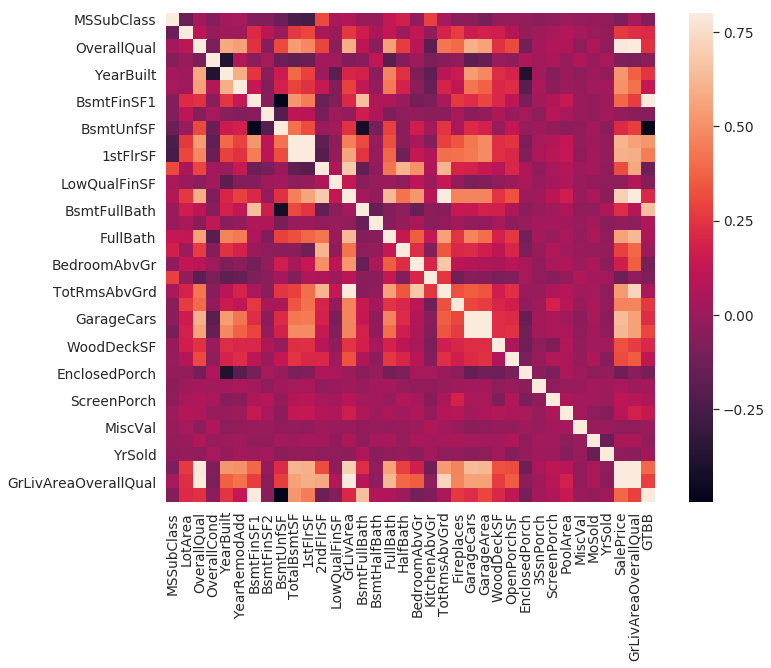

In [204]:
#correlation matrix
corrmat = df_int.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

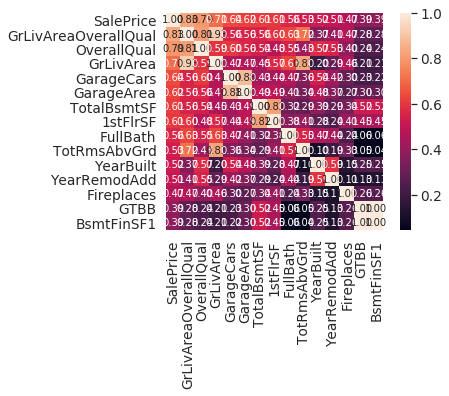

In [205]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

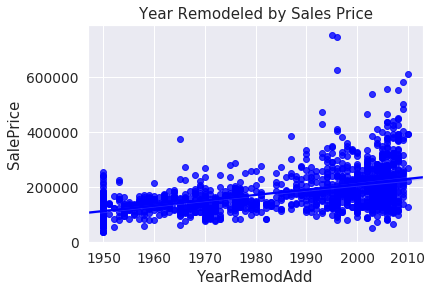

In [206]:
sns.regplot(df['YearRemodAdd'], df['SalePrice'], color='blue').set_title('Year Remodeled by Sales Price');

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [207]:
df_int.columns.tolist()

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'GrLivAreaOverallQual',
 'GTBB']

In [208]:
target = 'SalePrice'
features = ['MSSubClass',
            'LotArea',
            'OverallQual',
            'OverallCond',
            'YearBuilt',
            'YearRemodAdd',
            'BsmtFinSF1',
            'BsmtFinSF2',
            'BsmtUnfSF',
            'TotalBsmtSF',
            '1stFlrSF',
            '2ndFlrSF',
            'LowQualFinSF',
            'GrLivArea',
            'BsmtFullBath',
            'BsmtHalfBath',
            'FullBath',
            'HalfBath',
            'BedroomAbvGr',
            'KitchenAbvGr',
            'TotRmsAbvGrd',
            'Fireplaces',
            'GarageCars',
            'GarageArea',
            'WoodDeckSF',
            'OpenPorchSF',
            'EnclosedPorch',
            '3SsnPorch',
            'ScreenPorch',
            'PoolArea',
            'MiscVal',
            'MoSold',
            'YrSold',
            'SalePrice']

X = df[features]
y = df[target]

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.710e+28
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        22:11:27   Log-Likelihood:                 26476.
No. Observations:                1460   AIC:                        -5.289e+04
Df Residuals:                    1427   BIC:                        -5.271e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.083e-08   1.32e-07     -0.082

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

In [210]:
X_train_int = X_train.loc[:, X_train.dtypes == np.int64]
X_train_int.head().T

,254,1066,638,799,380
MSSubClass,20,60,30,50,50
LotArea,8400,7837,8777,7200,5000
OverallQual,5,6,5,5,5
OverallCond,6,7,7,7,6
YearBuilt,1957,1993,1910,1937,1924
YearRemodAdd,1957,1994,1950,1950,1950
BsmtFinSF1,922,0,0,569,218
BsmtFinSF2,0,0,0,0,0
BsmtUnfSF,392,799,796,162,808
TotalBsmtSF,1314,799,796,731,1026


In [211]:
# iszero = df[df == 0].count(axis=1)/len(df.columns)
# print(iszero.sort_values(ascending=False))

39      0.243902
533     0.243902
1011    0.243902
1218    0.231707
894     0.219512
78      0.219512
976     0.219512
156     0.219512
710     0.219512
705     0.219512
1412    0.219512
1000    0.219512
1049    0.219512
163     0.219512
843     0.219512
1321    0.219512
102     0.219512
1232    0.219512
1090    0.219512
736     0.219512
984     0.207317
17      0.207317
636     0.207317
954     0.207317
342     0.207317
1035    0.207317
1045    0.207317
90      0.207317
259     0.207317
968     0.207317
          ...   
610     0.097561
1253    0.097561
554     0.097561
1031    0.097561
176     0.097561
600     0.097561
859     0.097561
869     0.097561
1043    0.097561
167     0.097561
992     0.097561
1067    0.097561
661     0.085366
359     0.085366
112     0.085366
1298    0.085366
718     0.085366
510     0.085366
318     0.085366
159     0.085366
208     0.085366
766     0.085366
769     0.085366
846     0.085366
918     0.085366
953     0.073171
197     0.073171
1230    0.0731

In [212]:
y_train.shape, X_train.shape

((1168,), (1168, 81))

In [219]:
target = 'SalePrice'
features = ['MSSubClass',
            'LotArea',
            'OverallQual',
            'OverallCond',
            'YearBuilt',
            'YearRemodAdd',
            'BsmtFinSF1',
            'BsmtFinSF2',
            'BsmtUnfSF',
            'TotalBsmtSF',
            '1stFlrSF',
            '2ndFlrSF',
            'LowQualFinSF',
            'GrLivArea',
            'BsmtFullBath',
            'BsmtHalfBath',
            'FullBath',
            'HalfBath',
            'BedroomAbvGr',
            'KitchenAbvGr',
            'TotRmsAbvGrd',
            'Fireplaces',
            'GarageCars',
            'GarageArea',
            'WoodDeckSF',
            'OpenPorchSF',
            'EnclosedPorch',
            '3SsnPorch',
            'ScreenPorch',
            'PoolArea',
            'MiscVal',
            'MoSold',
            'YrSold']

X = X_train[features]
y = y_train

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     149.8
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        22:16:10   Log-Likelihood:                -13853.
No. Observations:                1168   AIC:                         2.777e+04
Df Residuals:                    1136   BIC:                         2.793e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.841e+04   1.59e+06     -0.030

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [220]:
features = ['LotArea',
            'OverallQual',
            'OverallCond',
            'TotalBsmtSF',
            'KitchenAbvGr',
            '1stFlrSF',
            '2ndFlrSF',
            'GarageArea',
            'GrLivAreaOverallQual',
            'GTBB']

X = X_train[features]
X.shape

(1168, 10)

In [221]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     383.4
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        22:16:32   Log-Likelihood:                -13949.
No. Observations:                1168   AIC:                         2.792e+04
Df Residuals:                    1157   BIC:                         2.798e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4.556e+04 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

In [0]:
#All the P-values are below .05 and therefore can reject the null hypothesis for each feature except sqft_lot.

## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [0]:
features = ['OverallQual',
            'GrLivAreaOverallQual',
            'GTBB']
X = X_train[features]
y = y_train

In [236]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     1087.
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        22:25:14   Log-Likelihood:                -14023.
No. Observations:                1168   AIC:                         2.805e+04
Df Residuals:                    1164   BIC:                         2.807e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.773e+04 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [0]:
X_train['ln_price'] = np.log(y_train)

In [239]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
pd.Series(vif, X.columns)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const                   29.694705
OverallQual              2.833203
GrLivAreaOverallQual     2.922895
GTBB                     1.078181
dtype: float64

## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [237]:
# Log-Linear Regression

y = X_train['ln_price']

# model = sm.OLS(y, X)
model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     750.7
Date:                Wed, 01 May 2019   Prob (F-statistic):          1.67e-271
Time:                        22:25:21   Log-Likelihood:                 198.22
No. Observations:                1168   AIC:                            -388.4
Df Residuals:                    1164   BIC:                            -368.2
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.8465 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

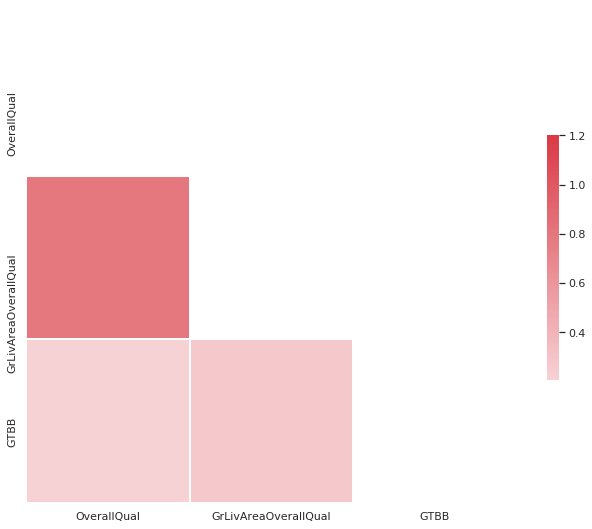

In [238]:
sns.set(style="white")

features = ['OverallQual',
            'GrLivAreaOverallQual',
            'GTBB']
# Generate a large random dataset
d = X_train[features]
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 2.3 If you have variables with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In [0]:
#Standard Errors Have Improved

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [260]:
#Robust Standard Errors HC3
model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     318.5
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        22:46:37   Log-Likelihood:                -13941.
No. Observations:                1168   AIC:                         2.791e+04
Df Residuals:                    1155   BIC:                         2.797e+04
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.433e+06 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

In [247]:
X_train['ln_price']

254     11.884489
1066    12.089539
638     11.350407
799     12.072541
380     11.751942
303     11.917724
86      12.066811
1385    11.740061
265     12.075394
793     12.323856
1445    11.767568
808     11.982617
1099    11.964001
605     12.230765
701     11.849398
221     12.206073
113     12.287653
548     11.736069
1073    11.979799
174     12.122691
514     11.477298
1350    12.206073
1145    11.911702
965     12.094582
936     12.127570
285     12.011881
1310    12.721886
342     11.379394
1165    12.359523
31      11.914048
          ...    
747     12.491173
252     12.061047
21      11.845103
1337    10.868568
459     11.608236
1184    12.137258
276     12.211060
955     11.884489
1215    11.736069
385     12.165251
805     12.335696
1437    12.885671
343     12.491252
769     13.195614
1332    11.512925
130     12.328290
871     12.208570
1123    11.678440
1396    11.982929
87      12.010666
330     11.686879
1238    11.867097
466     12.025749
121     11.512925
1044    12

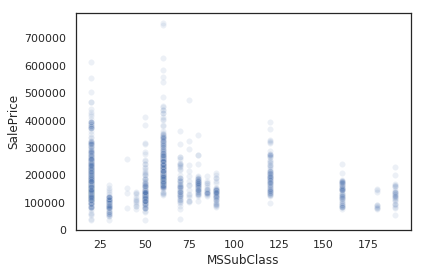

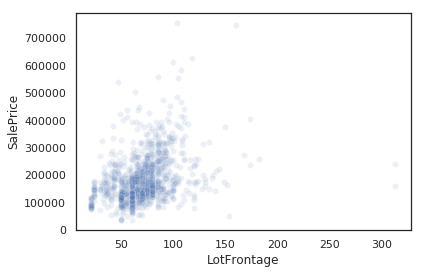

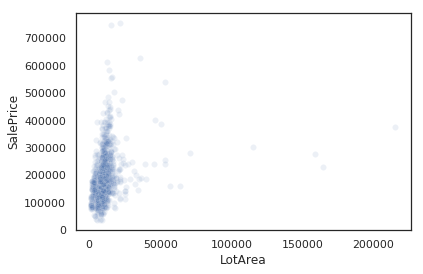

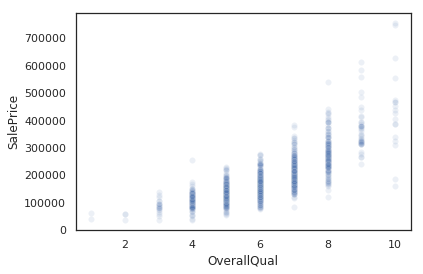

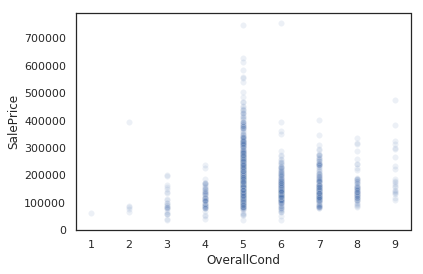

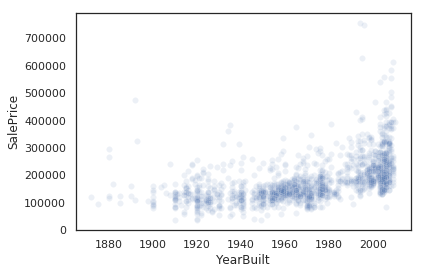

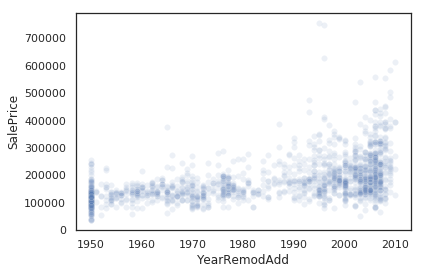

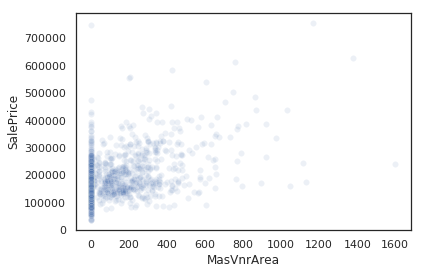

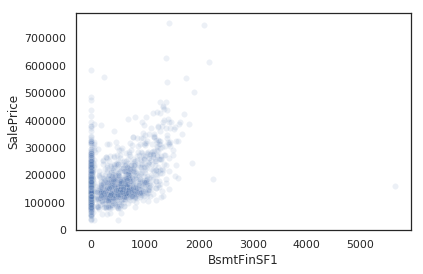

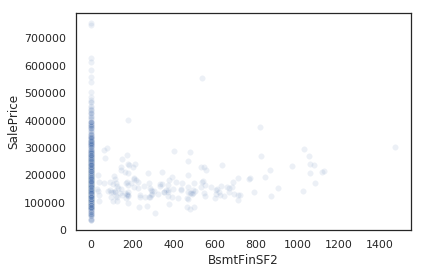

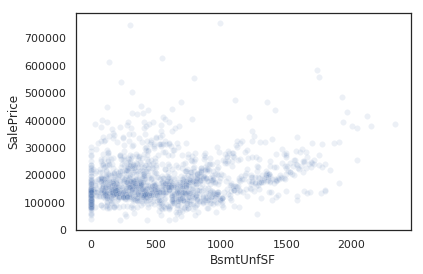

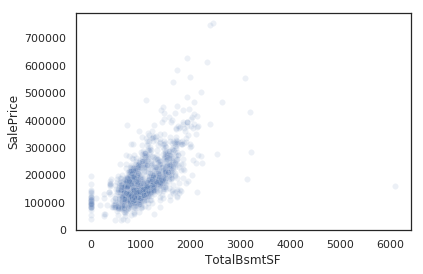

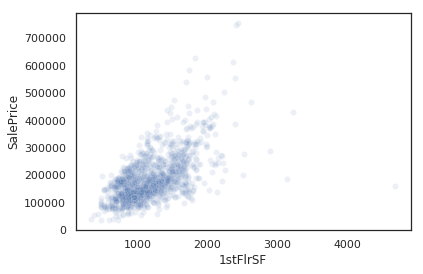

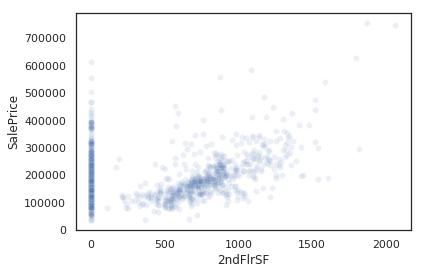

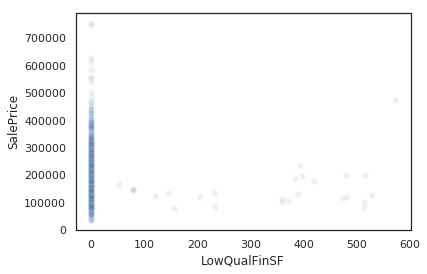

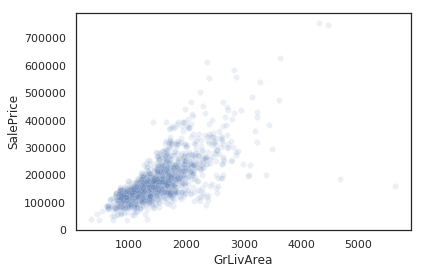

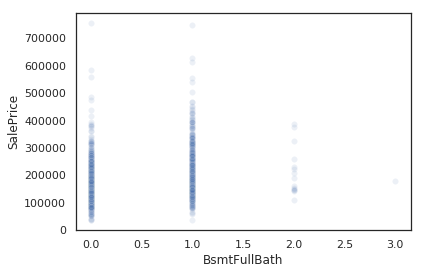

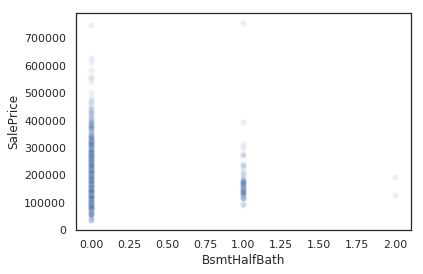

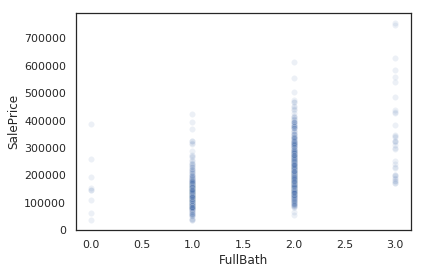

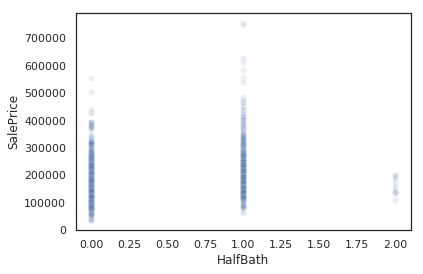

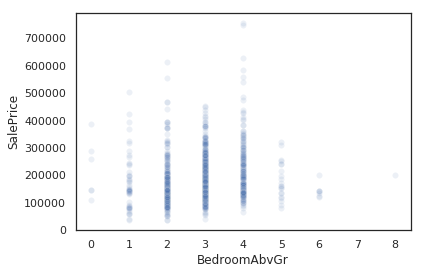

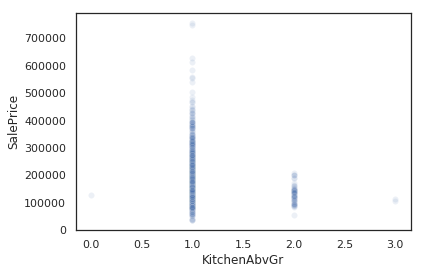

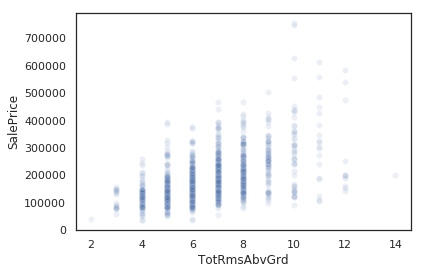

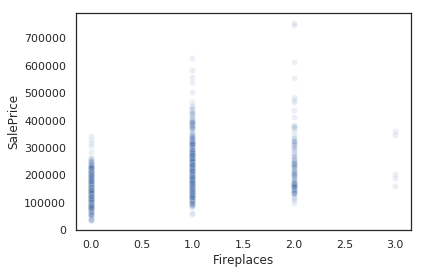

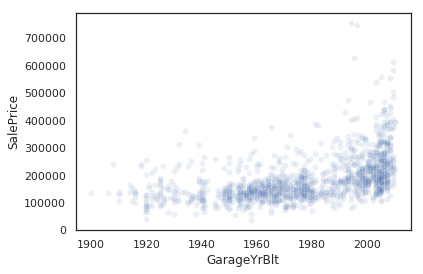

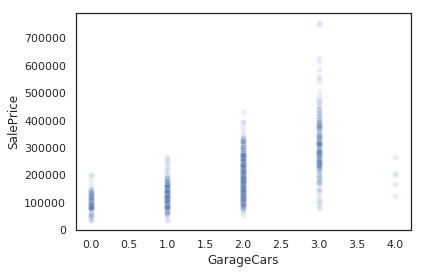

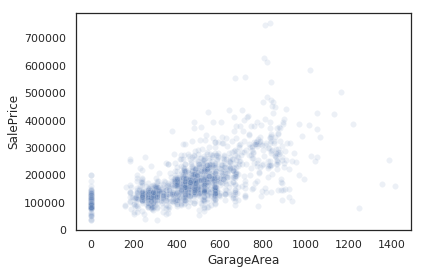

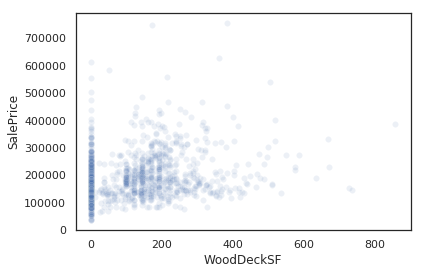

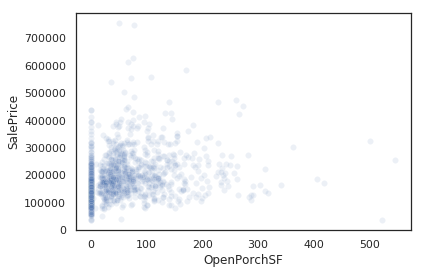

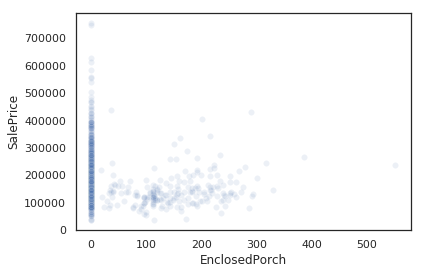

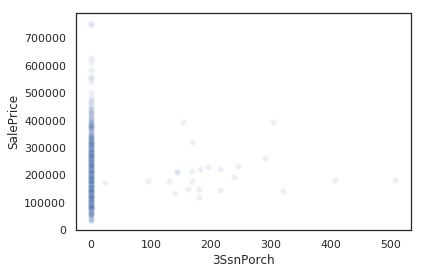

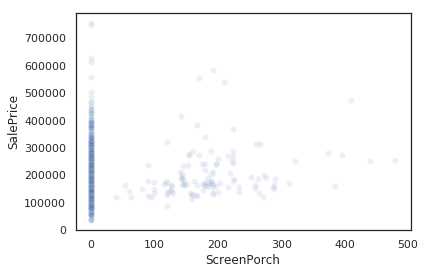

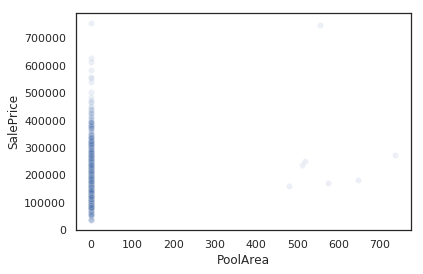

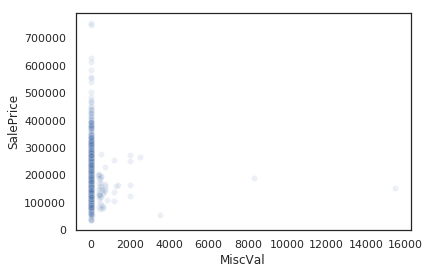

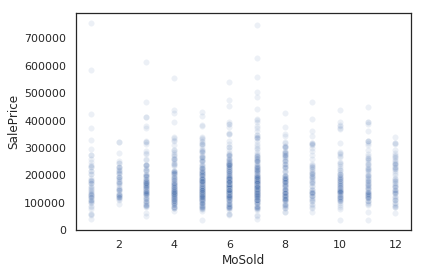

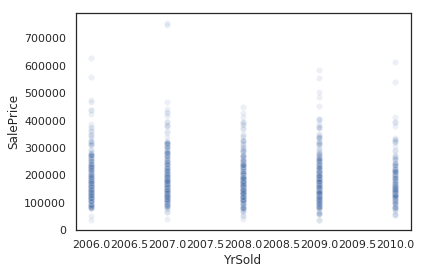

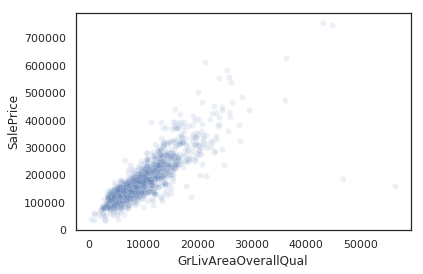

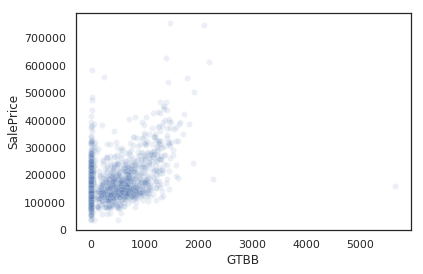

In [248]:
target = 'SalePrice'
numeric_columns = df.select_dtypes(include='number').columns
for feature in numeric_columns.drop(target):
    sns.scatterplot(x=feature, y=target, data=df, alpha=0.1)
    plt.show()

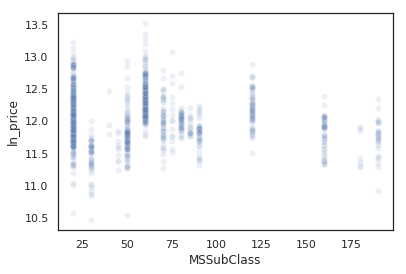

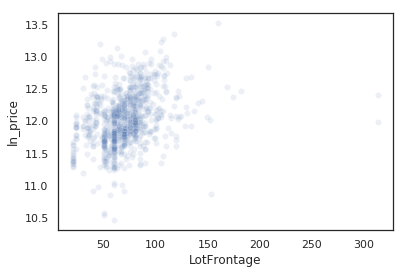

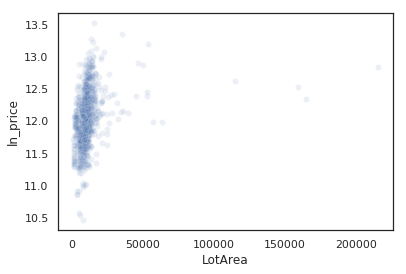

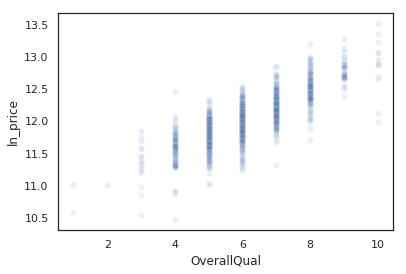

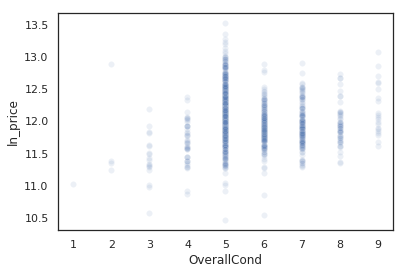

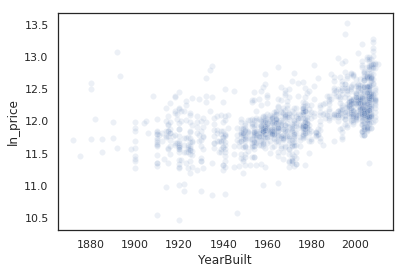

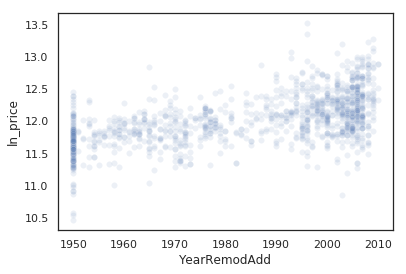

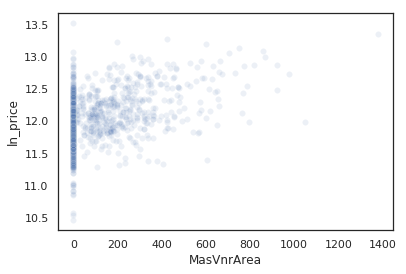

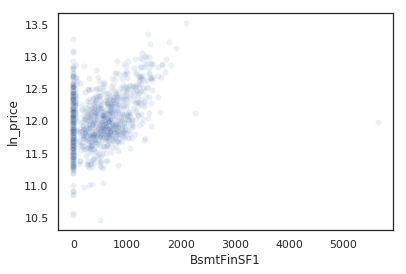

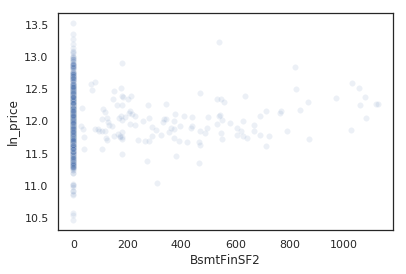

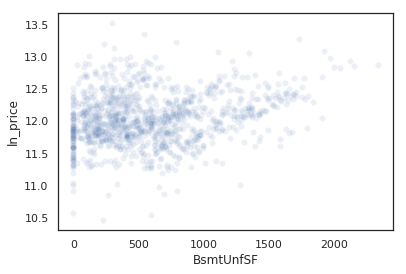

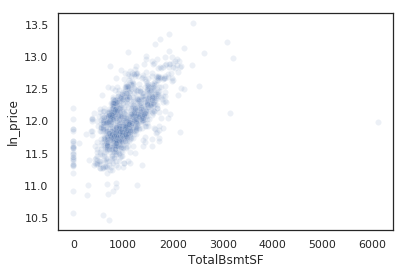

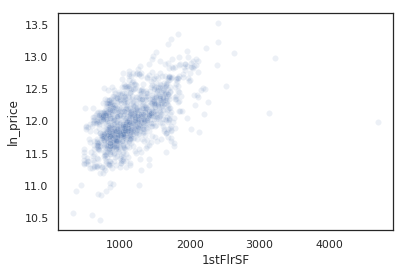

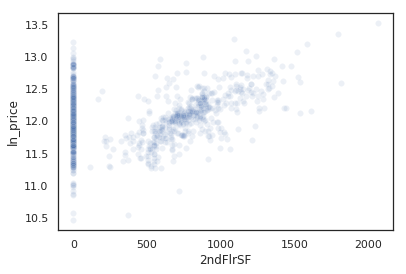

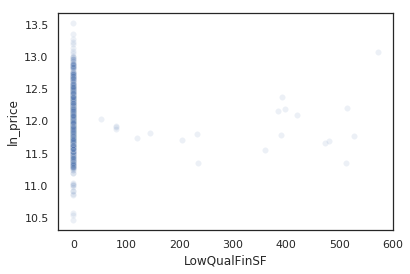

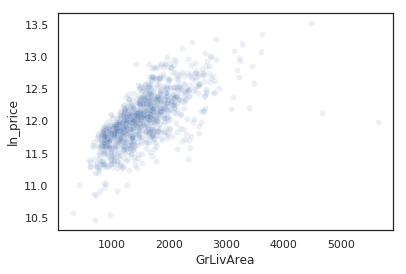

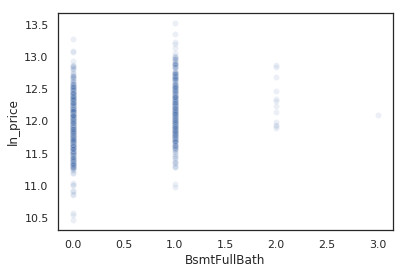

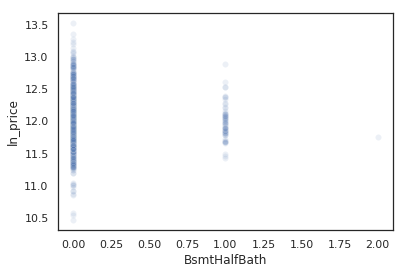

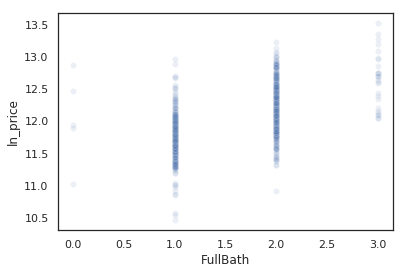

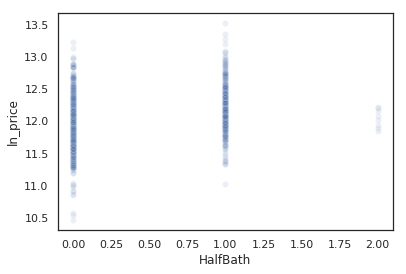

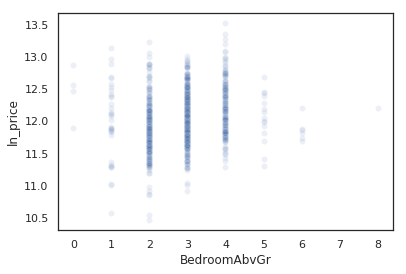

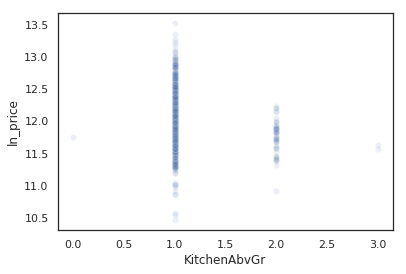

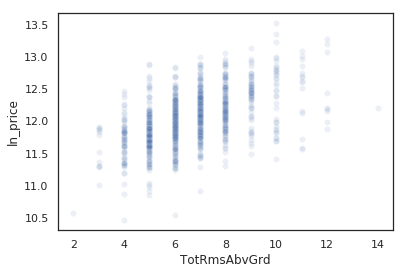

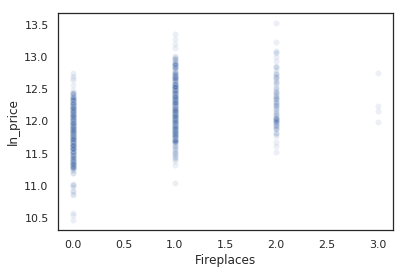

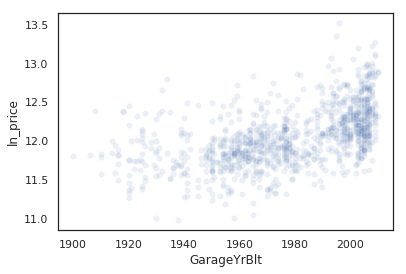

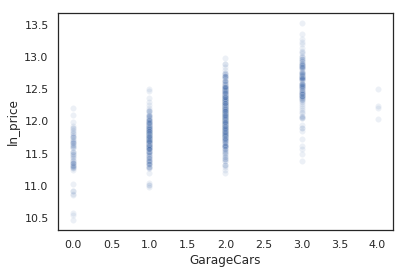

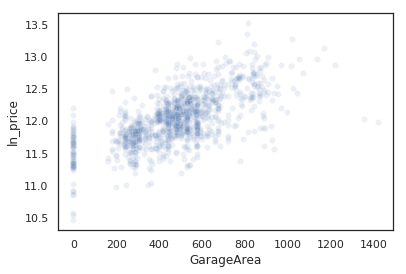

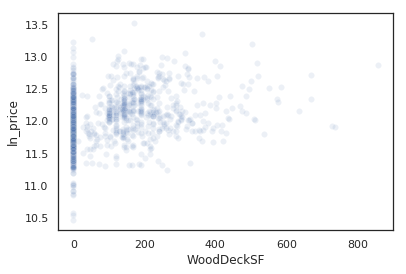

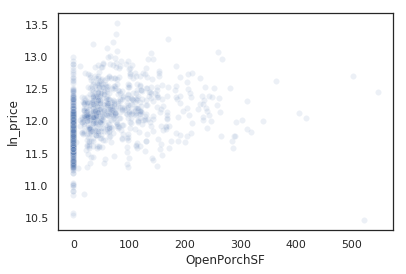

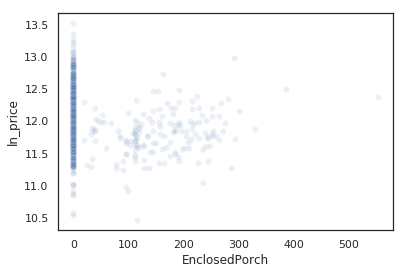

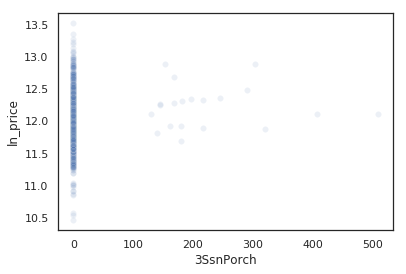

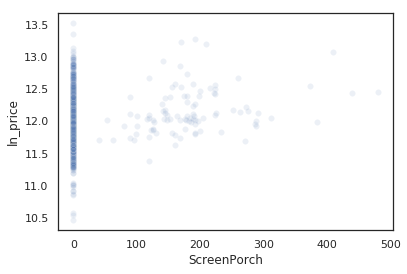

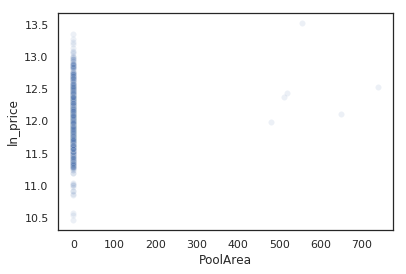

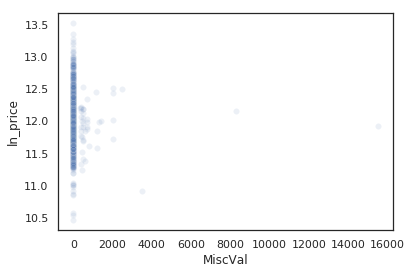

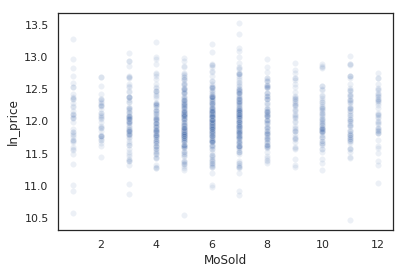

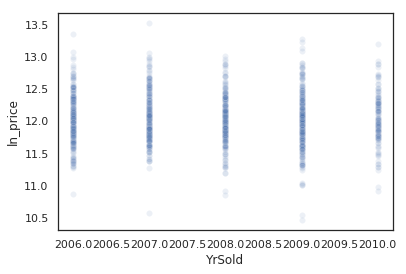

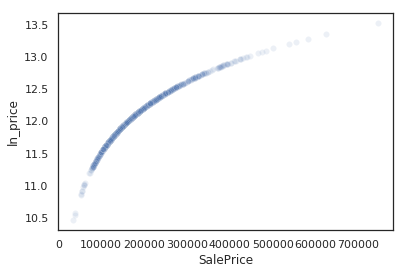

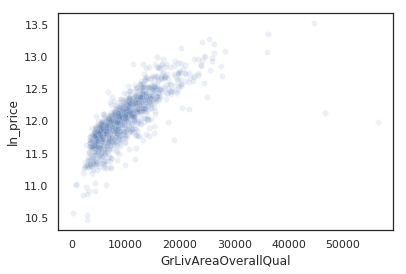

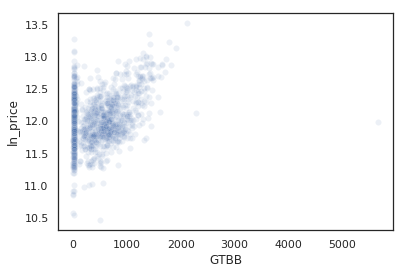

In [249]:
target = X_train['ln_price']
numeric_columns = df.select_dtypes(include='number').columns
for feature in numeric_columns:
    sns.scatterplot(x=feature, y=target, data=df, alpha=0.1)
    plt.show()


## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


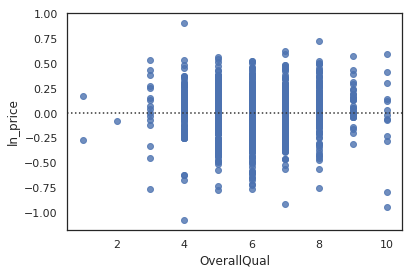

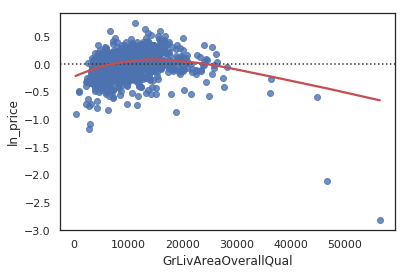

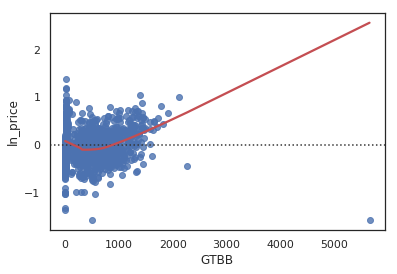

In [250]:
for feature in features:
    sns.residplot(X[feature], y, lowess=True, line_kws=dict(color='r'))
    plt.show()

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [0]:
X_train['bath'] = X_train['FullBath']+X_train['HalfBath']+df['BsmtFullBath']+df['BsmtHalfBath']

In [254]:
target = 'SalePrice'
features = ['YearBuilt',
            'YearRemodAdd',
            'TotalBsmtSF',
            '1stFlrSF',
            'GrLivArea',
            'BedroomAbvGr',
            'TotRmsAbvGrd',
            'YrSold',
            'OverallQual',
            'GrLivAreaOverallQual',
            'GTBB',
            'bath']

X = X_train[features]
y = y_train

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     324.6
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        22:41:29   Log-Likelihood:                -13941.
No. Observations:                1168   AIC:                         2.791e+04
Df Residuals:                    1155   BIC:                         2.797e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.433e+06 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [257]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
pd.Series(vif, X.columns)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const                   2.334717e+06
YearBuilt               2.611026e+00
YearRemodAdd            1.761886e+00
TotalBsmtSF             4.150571e+00
1stFlrSF                4.355577e+00
GrLivArea               2.823113e+01
BedroomAbvGr            2.222762e+00
TotRmsAbvGrd            4.421154e+00
YrSold                  1.010332e+00
OverallQual             7.731204e+00
GrLivAreaOverallQual    3.479617e+01
GTBB                    1.492900e+00
bath                    3.655072e+00
dtype: float64

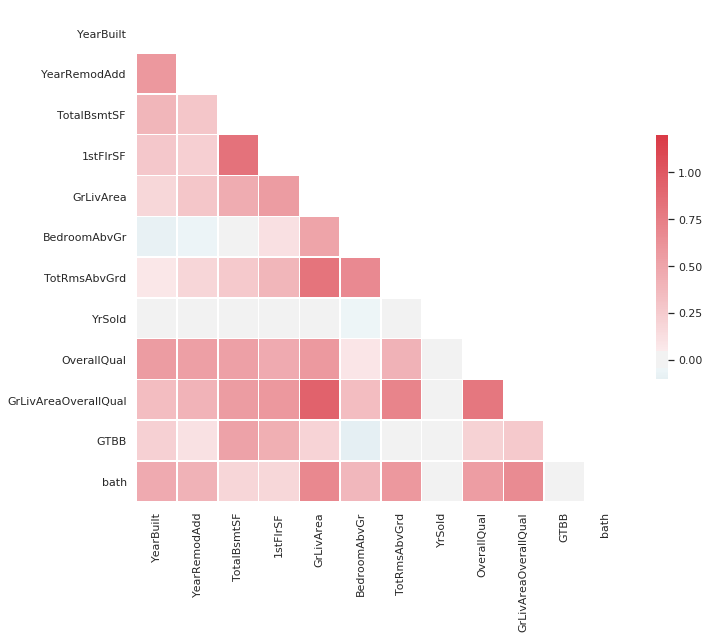

In [256]:
sns.set(style="white")

features = ['YearBuilt',
            'YearRemodAdd',
            'TotalBsmtSF',
            '1stFlrSF',
            'GrLivArea',
            'BedroomAbvGr',
            'TotRmsAbvGrd',
            'YrSold',
            'OverallQual',
            'GrLivAreaOverallQual',
            'GTBB',
            'bath']
# Generate a large random dataset
d = X_train[features]
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

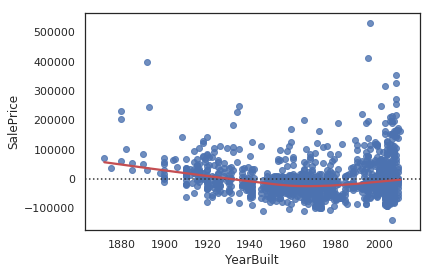

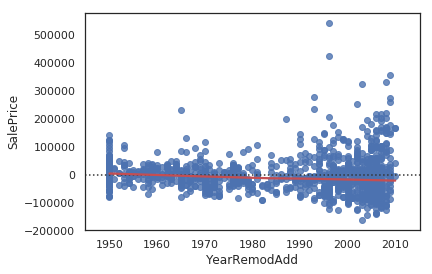

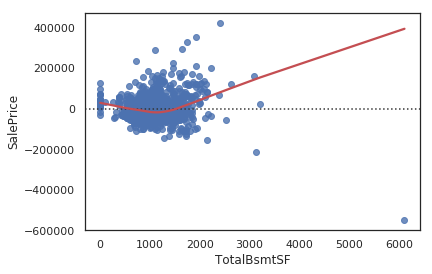

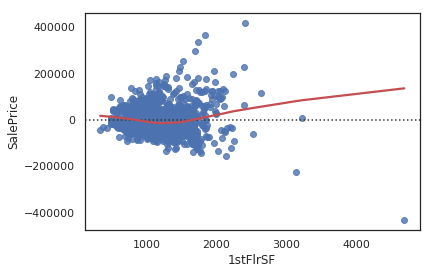

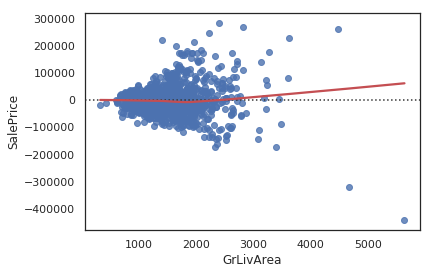

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


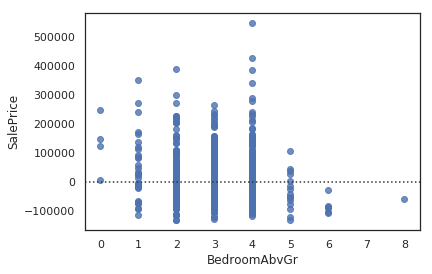

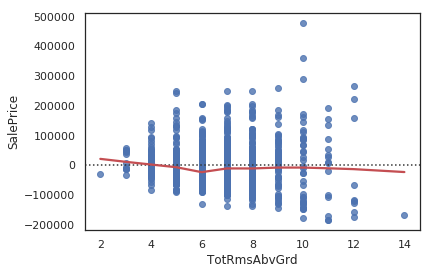

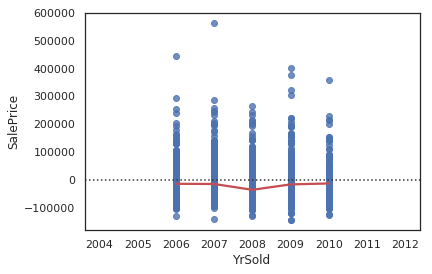

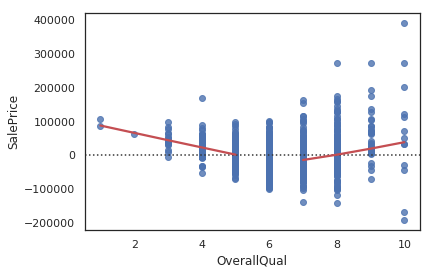

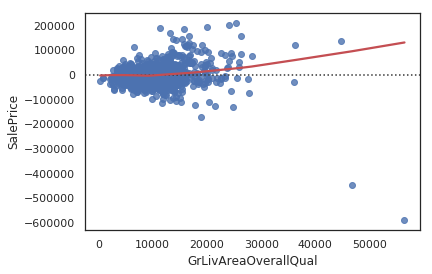

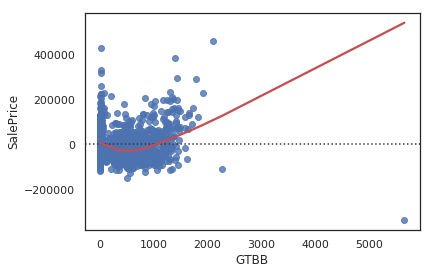

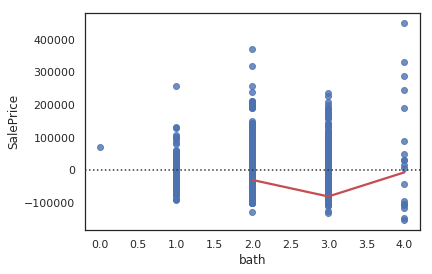

In [258]:
for feature in features:
    sns.residplot(X[feature], y, lowess=True, line_kws=dict(color='r'))
    plt.show()

In [261]:
#Robust Standard Errors
model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     318.5
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        22:46:58   Log-Likelihood:                -13941.
No. Observations:                1168   AIC:                         2.791e+04
Df Residuals:                    1155   BIC:                         2.797e+04
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.433e+06 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [262]:


def run_linear_model(X, y):
    # Split into test and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

    # Fit model using train data
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions using test features
    y_pred = model.predict(X_test)

    # Compare predictions to TEST target
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))#root mean square error, how far we are off by average
    r2 = r2_score(y_test, y_pred)#percentage off target, negative r score means you are doing worse

    print('Root Mean Squared Error', rmse)
    print('R^2 Score', r2)
    print('Intercept', model.intercept_)#print intercept
    coefficients = pd.Series(model.coef_, X_train.columns)
    print(coefficients.to_string())
    
run_linear_model(X, y)

Root Mean Squared Error 32801.38205392843
R^2 Score 0.8335454431282032
Intercept -2745717.092526625
const                       0.000000
YearBuilt                 337.225524
YearRemodAdd              287.913070
TotalBsmtSF                 1.397489
1stFlrSF                   22.420763
GrLivArea                   9.013537
BedroomAbvGr            -5510.016053
TotRmsAbvGrd             4938.003818
YrSold                    739.491026
OverallQual             16111.656053
GrLivAreaOverallQual        3.906597
GTBB                       16.414249
bath                     2019.509989


In [0]:
import statsmodels.stats.api as sms

In [265]:
finding confidence interval
sms.DescrStatsW(X).tconfint_mean()

(array([1.00000000e+00, 1.96920471e+03, 1.98370695e+03, 1.03647277e+03,
        1.14715595e+03, 1.49729457e+03, 2.84420533e+00, 6.46865873e+00,
        2.00774256e+03, 6.04306217e+00, 9.47011479e+03, 4.28407589e+02,
        1.91368527e+00]),
 array([1.00000000e+00, 1.97272679e+03, 1.98608757e+03, 1.08707004e+03,
        1.19155296e+03, 1.55750851e+03, 2.93661659e+00, 6.65462894e+00,
        2.00789442e+03, 6.20008852e+00, 1.00639160e+04, 4.81178027e+02,
        2.00412295e+00]))

# Stretch Goals

- Research the assumptions that are required for OLS to be BLUE the "Best Linear Unbiased Estimator". You might try searching and trying to understand the conditions of what's called the Gauss-Markov Theorem.
- Research other diagnostic tests. Can you show that residuals are normally distributed graphically?
- Write a blog post about inferential modeling using linear regression.